# Предсказание коэффициента восстановления золота

Проект на основе создания прототипа модели машинного обучения для компании "Цифра". Компания разрабатывает ррешения для эффективной работы промышленных компаний.
Цель работы заключается в предсказании коэффициента восстановления золота из руды.

## Загрузка библиотек и подготовка данных

### Загрузка библиотек

Загрузим необходимые библиотеки

In [1]:
# Выгрузка стандартных билиотек
import warnings
from numpy.random import RandomState

# Выгрузка сторонних библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Выгрузка модулей библиотек для машинного обучения
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    cross_val_score,
    RandomizedSearchCV
)
from sklearn.metrics import (
    mean_absolute_error,
    make_scorer
)

# Объявление константы для "фиксации случайности"
rnd_st = 12345
state = RandomState(rnd_st)
# Настройка игнорирования ошибок
warnings.filterwarnings("ignore")

Напишем фукнцию для первичного обзора данных

### Загрузка данных

Выгрузим данные в отдельные переменные

In [38]:
df_full = pd.read_csv('gold_recovery_full_new.csv')

df_test = pd.read_csv('gold_recovery_test_new.csv')

df_train = pd.read_csv('gold_recovery_train_new.csv')

### Проверка формулы вычисления эффективности обогащения

Эффективность обогащения рассчитывается по формуле: $Эффективность \ обогащения = \frac{C * (F-T)}{F*(C-T)}*100\%$
где:
[*] C — доля золота в концентрате после флотации/очистки;
[*] F — доля золота в сырье/концентрате до флотации/очистки;
[*] T — доля золота в отвальных хвостах после флотации/очистки.

Нам требуется рассчитать rougher.output.recovery по тестовой выборке и сопоставить c существующим значением. Оценивать будем по средней абсолютной ошибке (MAE)

In [3]:
T = df_train['rougher.output.tail_au']
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']

df_train['rougher.output.recovery.pred'] = ((C*(F - T))/(F*(C-T))) * 100

Рассчитаем MAE

In [ ]:
mean_absolute_error(df_train['rougher.output.recovery'], df_train['rougher.output.recovery.pred'])

In [5]:
df_train = df_train.drop('rougher.output.recovery.pred', axis=1)

**Вывод**: Значение ошибки предельно мало, эффективность обогащения в данных рассчитана корректно

### Сопоставление данных обучающей и тестовой выборки

Рассмотрим общую информацию об этих выборках

In [6]:
df_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Columns: 53 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(52), object(1)
memory usage: 2.1+ MB


In [7]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Columns: 87 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86), object(1)
memory usage: 9.4+ MB


Видно, что количество столбцов различаются и есть пропуски в обеих выборках. Рассмотрим, какие столбцы отсутствуют в тестовой выборке

In [8]:
a = df_train.columns.tolist()
for i in df_test.columns:
    if i in a:
        a.remove(i)
a

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**Промежуточный вывод:** Определено, что отсутствуют столбцы, характеризующие параметры продукта 'output' и расчетные характеристики 'calculation'.
1. Значения параметров продукта отсутствуют, так как их можно узнать только после каждой стадии производства.
2. Значения расчетных характеристик вероятнее всего не имеют целевого значения и считаются служебными, ссылаясь на их названия ('sulfate_to_au_concentrate', 'floatbank10_sulfate_to_au_feed', 'floatbank11_sulfate_to_au_feed', 'au_pb_ratio'.

### Предобработка данных

#### Перевод в корректные типы данных

Видно, что дата имеет некорректный формат. Переведем его в Datetime.

In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

Помимо этого, стоит округлить значения дат в тестовых и тренировочных выборках до часов, как представлено в полном датафрейме.

In [12]:
for df in [df_full, df_train, df_test]:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').round('H')


#### Работа с пропусками

Оценим количество пропущенных значений в тренировочной и тестовой выборках

In [13]:
df_train.isna().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [14]:
df_test.isna().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

С учетом того, что Соседние по времени параметры часто похожи, предлагается заполнять пропуски близким по часу предыдущим значением.

In [15]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')

In [16]:
df_train.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [17]:
df_test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

#### Удаление лишних столбцов из тренировочной выборки

Уравняем количество столбцов в выборках, но перед этим добавим в тестовую выборку два столбца с целевыми признаками

In [18]:
for column in ['rougher.output.recovery', 'final.output.recovery']:
    df_test[column] = (
        df_full.loc[df_full['date'].isin(df_test['date']), column]
        .reset_index(drop=True)
    )

In [19]:
for i in df_train.columns:
    if i not in df_test.columns:
        df_train = df_train.drop(i, axis=1)

## Анализ данных

### Исследование изменения концентрации элементов на каждом этапе

Для начала выделим данные под каждый элемент. В данных должны содержаться столбцы с концентрациями на каждом этапе обработки руды.

In [20]:
for val in ['au', 'ag', 'pb']:
    globals()[f"df_{val}"] = df_full[[f'rougher.input.feed_{val}',
                                      f'rougher.output.concentrate_{val}',
                                      f'primary_cleaner.output.concentrate_{val}',
                                      f'final.output.concentrate_{val}']]
    globals()[f"df_{val}"].columns = ['Исходная','Флотация','Первичная_очистка','Вторичная_очистка']


Построим "Ящики с усами" для визуального анализа.

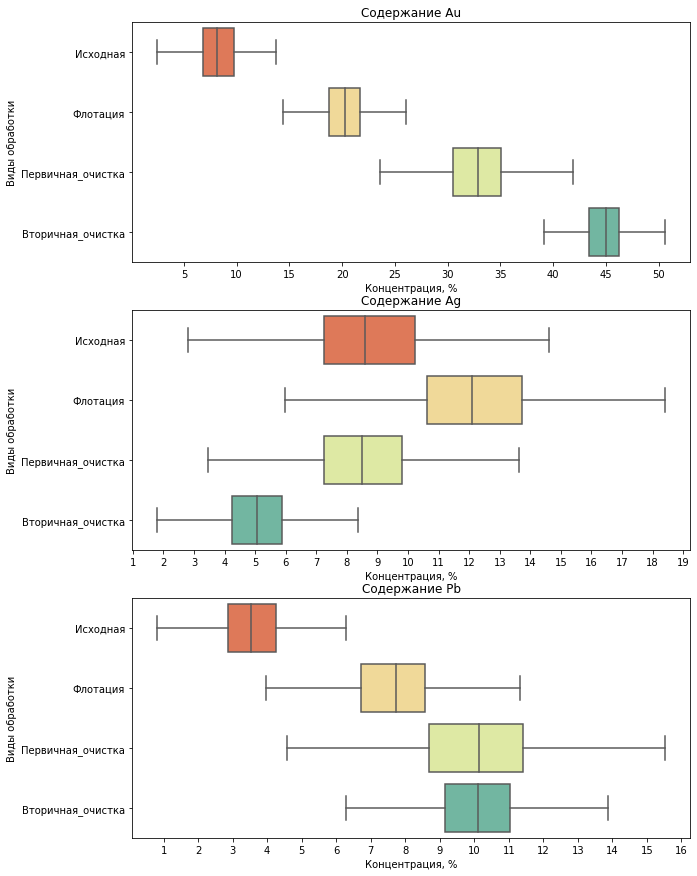

In [21]:
fig, ax = plt.subplots(3,1, figsize=(10,15))
for ind, val in enumerate(['Au', 'Ag', 'Pb']):
    ax[ind].set_title(f'Содержание {val}')
    ax[ind].set_ylabel('Виды обработки')
    ax[ind].set_xlabel('Концентрация, %')
    ax[ind].locator_params(axis='x', nbins= 20)
    sns.boxplot(data=globals()[f"df_{val.lower()}"], ax=ax[ind], showfliers=False, palette='Spectral', orient='h',)

**Промежуточный вывод:**
*Флотация:*
После проведения флотации концентрации всех рассматриваемых веществ повышаются.
*Первичная очистка:*
Концентрация золота и свинца растет, а концентрация серебра начинает значительно падать.
*Вторичная очистка:*
Концентрация золота на момент финального этапа обработки выросла до 45% (Выросла на ~37,5%), концентрация серебра также падает (Финальная концентрация уменьшилась на ~3.5% относительно исходного значения), а концентрация свинца остается на том же месте (~10%)

### Анализ распределения размеров гранул ***сырья*** на обучающей и тестовой выборках

Выделим данные в отдельные переменные:

In [22]:
df_train_size = df_train['rougher.input.feed_size']
df_test_size = df_test['rougher.input.feed_size']

Перед построением графиков посмотрим на средние и медианные значения выборок

In [23]:
print(f'Среднее тестовой выборки: {df_test_size.mean()}')
print(f'Медиана тестовой выборки: {df_test_size.median()}')
print(f'Среднее тренировочной выборки: {df_train_size.mean()}')
print(f'Медиана тренировочной выборки: {df_train_size.median()}')

Среднее тестовой выборки: 55.952754028895136
Медиана тестовой выборки: 50.8468431600362
Среднее тренировочной выборки: 60.23985599255732
Медиана тренировочной выборки: 55.269783890501536


Построим гистограммы и кривые плотностей к ней:

Text(0.5, 0, 'Размер гранул')

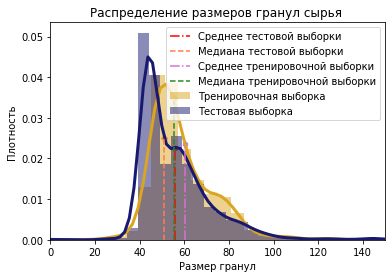

In [24]:

sns.distplot(df_train_size,
             label="Тренировочная выборка",
             bins=80,
             color="goldenrod",
             hist_kws={'alpha':.5},
             kde_kws={'linewidth':3, 'alpha':.7})

sns.distplot(df_test_size,
             label="Тестовая выборка",
             bins=80,
             color="midnightblue",
             hist_kws={'alpha':.5},
             kde_kws={'linewidth':3, 'alpha':.7})

plt.axvline(x=df_test_size.mean(), ymax=0.41, linestyle='-.', color="red", label="Среднее тестовой выборки")
plt.scatter(x=df_test_size.mean(), y=0.0225, s=20, color="red", alpha=1)
plt.axvline(x=df_test_size.median(), ymax=0.47, linestyle='--', color="coral", label="Медиана тестовой выборки")
plt.scatter(x=df_test_size.median(), y=0.025, s=20, marker='D', color="coral", alpha=1)

plt.axvline(x=df_train_size.mean(), ymax=0.43, linestyle='-.', color="orchid", label="Среднее тренировочной выборки")
plt.scatter(x=df_train_size.mean(), y=0.0235, s=20, color="orchid", alpha=1)
plt.axvline(x=df_train_size.median(), ymax=0.64, linestyle='--', color="forestgreen", label="Медиана тренировочной выборки")
plt.scatter(x=df_train_size.median(), y=0.035, s=20, marker='D', color="forestgreen", alpha=1)

plt.legend()
plt.title('Распределение размеров гранул сырья ', fontsize=12)
plt.xlim(0,150)
plt.ylabel('Плотность')
plt.xlabel('Размер гранул')


***Промежуточный вывод:***
По приведенным графикам видно, что распределение гранул сырья в тренировочной и тестовой выборках примерно схожи, соответственно оценка модели не под угрозой.

### Анализ суммарной концентрации всех веществ на разных стадиях

Просуммируем все концентрации на каждом этапе производства

In [25]:
df_full['input_sum'] = df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_sol'] + df_full['rougher.input.feed_pb']

df_full['rougher_sum'] = df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_au'] + df_full['rougher.output.concentrate_sol'] + df_full['rougher.output.concentrate_pb']

df_full['final_sum'] = df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_au'] + df_full['final.output.concentrate_sol'] + df_full['final.output.concentrate_pb']

Построим графики

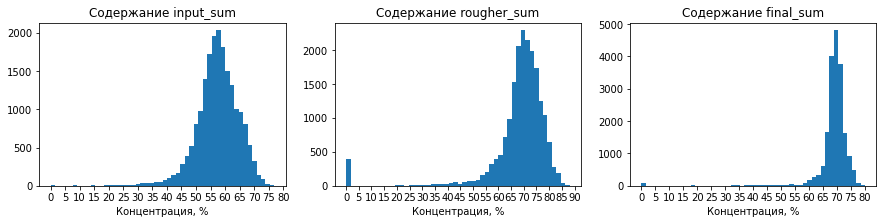

In [26]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
for ind, val in enumerate(['input_sum', 'rougher_sum', 'final_sum']):
    ax[ind].set_title(f'Содержание {val}')
    ax[ind].set_xlabel('Концентрация, %')
    ax[ind].locator_params(axis='x', nbins= 20)
    ax[ind].hist(df_full[val], bins=50)

Отсечем аномально низкие значения

In [27]:
df_full = df_full.loc[(df_full[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']].sum(axis=1)>20) &
    (df_full[['final.output.concentrate_au', 'final.output.concentrate_ag',
    'final.output.concentrate_pb', 'final.output.concentrate_sol']].sum(axis=1)>20)]

Построим график еще раз по такому же принципу

In [28]:
df_full['input_sum'] = df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_sol'] + df_full['rougher.input.feed_pb']

df_full['rougher_sum'] = df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_au'] + df_full['rougher.output.concentrate_sol'] + df_full['rougher.output.concentrate_pb']

df_full['final_sum'] = df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_au'] + df_full['final.output.concentrate_sol'] + df_full['final.output.concentrate_pb']

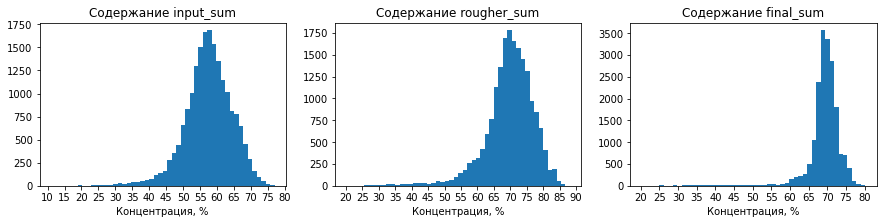

In [29]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
for ind, val in enumerate(['input_sum', 'rougher_sum', 'final_sum']):
    ax[ind].set_title(f'Содержание {val}')
    ax[ind].set_xlabel('Концентрация, %')
    ax[ind].locator_params(axis='x', nbins= 20)
    ax[ind].hist(df_full[val], bins=50)

Теперь удалим те же строки из обучающей и тестовой выборок

In [30]:
df_train = df_train.loc[df_train['date'].isin(df_full['date'])].reset_index(drop=True)
df_test = df_test.loc[df_test['date'].isin(df_full['date'])].reset_index(drop=True)

***Промежуточный вывод:***
Опираясь на построенные гистограммы были удалены некорректные данные

## Построение модели

### Функция для вычисления итогового sMAPE

In [31]:
def smape(y, y_pred):
    smape = ( 2 / len(y) * sum(abs(y - y_pred) / (abs(y) + abs(y_pred))))
    return smape

In [32]:
def full_smape(rough, final):
    full_smape = 0.25 * rough + 0.75 * final
    return full_smape

In [33]:
metric_smape = make_scorer(smape, greater_is_better=False)

### Разделение данных на обучающую и тестовую выборки и масштабирование

In [34]:
features_train = df_train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = df_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = df_train[['rougher.output.recovery', 'final.output.recovery']]
target_test = df_test[['rougher.output.recovery', 'final.output.recovery']]

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_test)

### Обучение моделей

#### Линейная регрессия

In [35]:
model = LinearRegression()

score_rougher = cross_val_score(model,
                                features_train,
                                target_train['rougher.output.recovery'],
                                scoring=metric_smape,
                                cv=5)
score_final = cross_val_score(model,
                              features_train,
                              target_train['final.output.recovery'],
                              scoring=metric_smape,
                              cv=5)

print(f'SMAPE для чернового концентрата: {score_rougher.mean() * -1}')
print(f'SMAPE для конечного концентрата: {score_final.mean() * -1}')
print(f'Итоговая метрика: {-1 * full_smape(score_rougher.mean(), score_final.mean())}')

SMAPE для чернового концентрата: 0.0716921223037057
SMAPE для конечного концентрата: 0.1094065764272942
Итоговая метрика: 0.09997796289639707


#### Решающее дерево

In [36]:
model = DecisionTreeRegressor(random_state=rnd_st)
params = {'max_depth':range(1,21,1)}
grid = RandomizedSearchCV(model, params, scoring=metric_smape, cv=5, random_state=rnd_st)

grid.fit(features_train, target_train['rougher.output.recovery'])

print(f"Гиперпараметры лучшей модели решающего дерева для rougher.output.recovery: ",
      grid.best_params_)
score_rougher = grid.best_score_
print(f'SMAPE для чернового концентрата: {-1 * score_rougher}')

grid.fit(features_train, target_train['final.output.recovery'])

print(f"Гиперпараметры лучшей модели решающего дерева для final.output.recovery: ",
      grid.best_params_)
score_final = grid.best_score_
print(f'SMAPE для конечного концентрата: {-1 * score_final}')

print(f'Итоговая метрика: {-1 * full_smape(score_rougher, score_final)}')

Гиперпараметры лучшей модели решающего дерева для rougher.output.recovery:  {'max_depth': 4}
SMAPE для чернового концентрата: 0.07179525313840535
Гиперпараметры лучшей модели решающего дерева для final.output.recovery:  {'max_depth': 1}
SMAPE для конечного концентрата: 0.0973892300714507
Итоговая метрика: 0.09099073583818935


#### Случайный лес

In [37]:
model = RandomForestRegressor(random_state=rnd_st)
params = { 'n_estimators': range (10, 51, 5),
           'max_depth': range (1,11, 1) }

grid = RandomizedSearchCV(model, params, scoring=metric_smape, cv=5)

grid.fit(features_train, target_train['rougher.output.recovery'])
print(f"Гиперпараметры лучшей модели случайного леса для 'rougher.output.recovery': ", grid.best_params_)
score_rougher = grid.best_score_

grid.fit(features_train, target_train['final.output.recovery'])
print(f"Гиперпараметры лучшей модели случайного леса для 'final.output.recovery': ", grid.best_params_)
score_final = grid.best_score_


print('sMAPE моделей случайного леса на обучающей выборке:')
print(-1 * score_rougher)
print(-1 * score_final)
print('Итоговое sMAPE моделей случайного леса на обучающей выборке: ', -1 * full_smape(score_rougher, score_final))

Гиперпараметры лучшей модели случайного леса для 'rougher.output.recovery':  {'n_estimators': 30, 'max_depth': 5}
Гиперпараметры лучшей модели случайного леса для 'final.output.recovery':  {'n_estimators': 45, 'max_depth': 3}
sMAPE моделей случайного леса на обучающей выборке:
0.06376652229977853
0.0912286570711768
Итоговое sMAPE моделей случайного леса на обучающей выборке:  -0.08436312337832724


#### Константная модель

In [38]:
model = DummyRegressor(strategy="median")
score_rougher = cross_val_score(model,
                                features_train,
                                target_train['rougher.output.recovery'],
                                scoring=metric_smape,
                                cv=5)
score_final = cross_val_score(model,
                              features_train,
                              target_train['final.output.recovery'],
                              scoring=metric_smape,
                              cv=5)

print(f'SMAPE для чернового концентрата: {-1 * score_rougher.mean()}')
print(f'SMAPE для конечного концентрата: {-1 * score_final.mean()}')
print(f'Итоговая метрика: {-1 * full_smape(score_rougher.mean(), score_final.mean())}')

SMAPE для чернового концентрата: 0.07765934227792015
SMAPE для конечного концентрата: 0.10387418202263318
Итоговая метрика: 0.09732047208645492


***Промежуточный вывод:***
Лучшей моделью оказался случайный лес. Проверим ее на тестовой выборке.
Гиперпараметры лучших моделей:
- Гиперпараметры лучшей модели случайного леса для 'rougher.output.recovery':  {'n_estimators': 30, 'max_depth': 5}
- Гиперпараметры лучшей модели случайного леса для 'final.output.recovery':  {'n_estimators': 45, 'max_depth': 3}

### Проверка лучшей модели на тестовой выборке

In [44]:

model_rougher = RandomForestRegressor(random_state=rnd_st, max_depth=5, n_estimators=30)
model_final = RandomForestRegressor(random_state=rnd_st, max_depth=3, n_estimators=45)


model_rougher.fit(features_train, target_train['rougher.output.recovery'])
model_final.fit(features_train, target_train['final.output.recovery'])


pred_rougher = model_rougher.predict(features_test)
pred_final = model_final.predict(features_test)

score_rougher = smape(target_test['rougher.output.recovery'], pred_rougher)
score_final = smape(target_test['final.output.recovery'], pred_final)

print('SMAPE моделей случайного леса на тестовой выборке:')
print(score_rougher)
print(score_final)

# Оценим итоговое sMAPE
print('Итоговое SMAPE моделей случайного леса на тестовой выборке: ',
      full_smape(score_rougher, score_final))

SMAPE моделей случайного леса на тестовой выборке:
0.04723654805899379
0.07725573830761376
Итоговое SMAPE моделей случайного леса на тестовой выборке:  0.06975094074545876


**Промежуточный вывод:** Итоговое SMAPE равно 0.069 или 6.9%

## Вывод

По результатам проведенной работы была проведена успешная предобработка данных. Помимо этого, по результатам анализа данных было исследовано распределение концентрации элементов на каждом этапе. После проведения флотации концентрации всех рассматриваемых веществ повышаются. Концентрация золота и свинца после первичной очистки растет, а концентрация серебра начинает значительно падать. Концентрация золота на момент финального этапа обработки выросла до 45% (Выросла на 37,5%), концентрация серебра также падает (Финальная концентрация уменьшилась на ~3.5% относительно исходного значения), а концентрация свинца остается на том же месте (10%). По результатам машинного обучения было установлено, что лучшей моделью оказался случайный лес. Итоговое значение smape на тестовой выборке оказалось 6.9%